In [131]:
# !pip install networkx
from collections import defaultdict, deque
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
import time
from itertools import permutations

In [132]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [133]:
def schedule_permutations(schedule):
    for perm in permutations(schedule):
        yield perm

In [134]:
def is_valid_schedule(schedule, edges):
    """Check if the schedule respects the precedence constraints."""
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [135]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [142]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [159]:
#brute force alg
def brute_force_alg(edges):
    start_time = time.time()
    graph, predak = inicialize_graph(edges)
    min_S = float('inf')
    for permutation in schedule_permutations(tasks):
        if is_valid_schedule(permutation, edges):
            S, maximum_S = calculate_S(permutation, graph, delays, predak)
            min_S = min(maximum_S, min_S)
            best_permutation = permutation
    
    end_time = time.time()
    time_taken = end_time - start_time
    print("Best order of tasks:", best_permutation)
    print("S:", S)
    print("Minimal S:", min_S)
    print("Time taken to find the solution:", time_taken)
    return best_permutation, S, min_S, time_taken 

In [148]:
brute_force_alg(edges)

Best order of tasks: ('A', 'C', 'B', 'D', 'E')
S: {'A': 1, 'C': 3, 'B': 4, 'D': 8, 'E': 10}
Minimal S: 10


In [146]:
def draw_graph(tasks, edges, delays):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    
    # Add edges with weights (delays)
    G.add_edges_from(edges)
    
    # Define positions for nodes using a layout
    pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=20)
    
    # Draw the delays as separate text next to the nodes
    for node, (x, y) in pos.items():
        plt.text(x + 0.09, y - 0.075, s=f"Delay: {delays[node]}", bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=12, color='blue')
    
    # Show the plot
    plt.show()

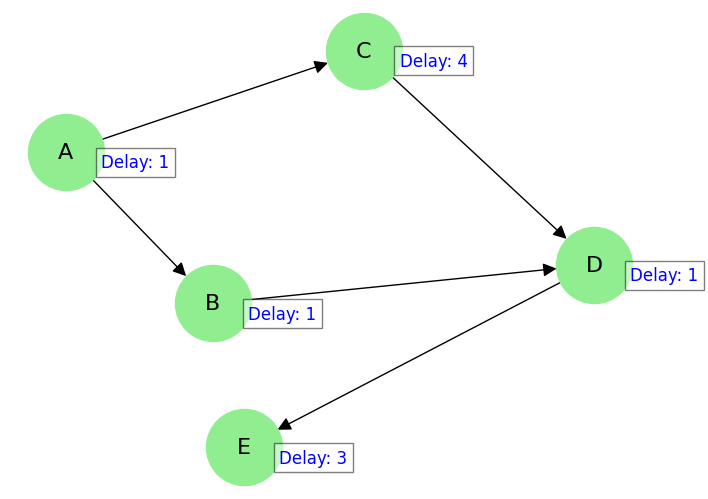

Best order of tasks: ('A', 'C', 'B', 'D', 'E')
S: {'A': 1, 'C': 3, 'B': 4, 'D': 8, 'E': 10}
Minimal S: 10


In [151]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}
draw_graph(tasks, edges, delays)

order_of_tasks, S, result = brute_force_alg(edges)

In [161]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

Best order of tasks: ('A', 'B', 'C', 'D', 'E')
S: {'A': 1, 'B': 3, 'C': 4, 'D': 6, 'E': 5}
Minimal S: 6
Time taken to find the solution: 0.0


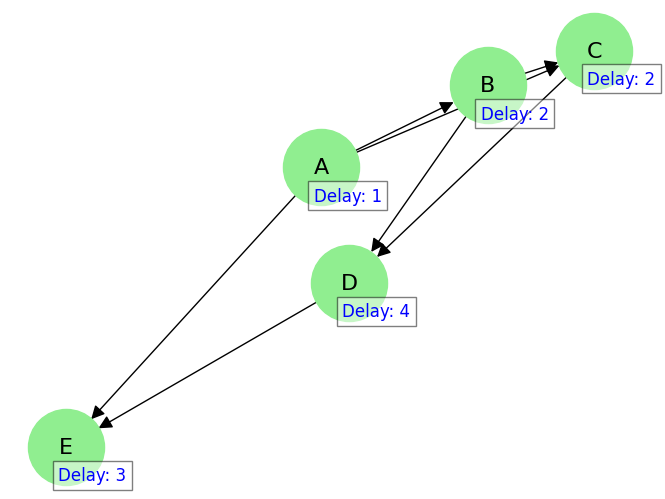

----------------------------------------------
Best order of tasks: ('A', 'B', 'C', 'D', 'E', 'F')
S: {'A': 1, 'B': 5, 'C': 6, 'D': 7, 'E': 8, 'F': 13}
Minimal S: 13
Time taken to find the solution: 0.0009975433349609375


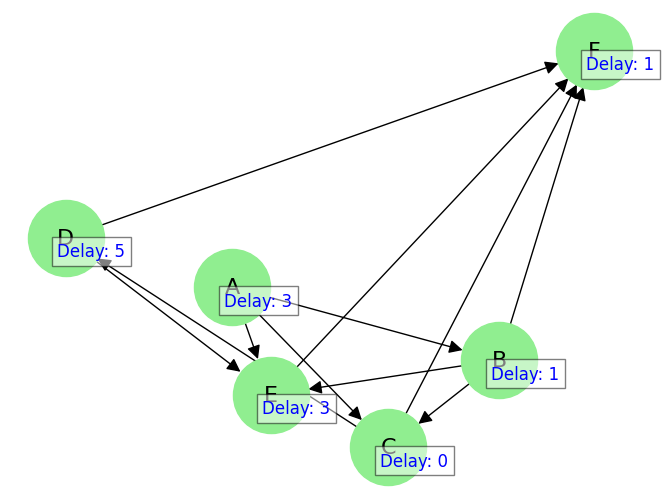

----------------------------------------------
Best order of tasks: ('A', 'B', 'C', 'D', 'E', 'F', 'G')
S: {'A': 1, 'B': 7, 'C': 8, 'D': 9, 'E': 14, 'F': 11, 'G': 19}
Minimal S: 19
Time taken to find the solution: 0.0039293766021728516


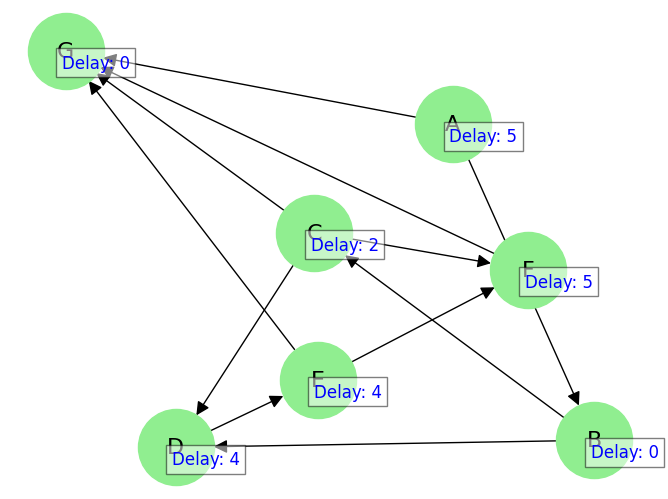

----------------------------------------------
Best order of tasks: ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
S: {'A': 1, 'B': 3, 'C': 4, 'D': 5, 'E': 6, 'F': 11, 'G': 7, 'H': 16}
Minimal S: 16
Time taken to find the solution: 0.030910015106201172


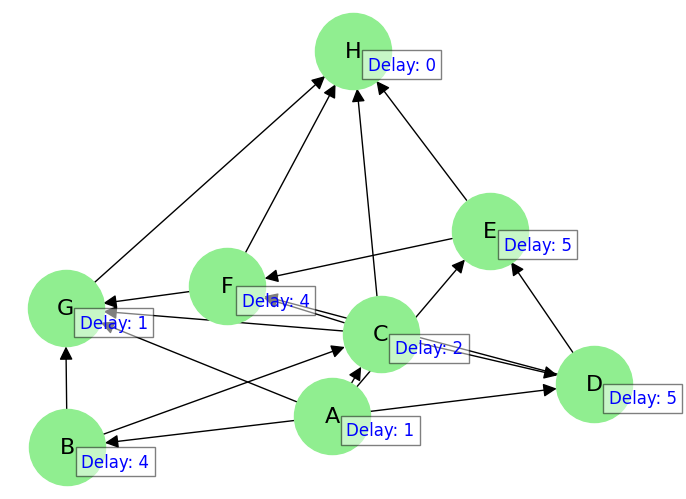

----------------------------------------------
Best order of tasks: ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')
S: {'A': 1, 'B': 2, 'C': 8, 'D': 12, 'E': 13, 'F': 14, 'G': 3, 'H': 19, 'I': 5}
Minimal S: 19
Time taken to find the solution: 0.2780182361602783


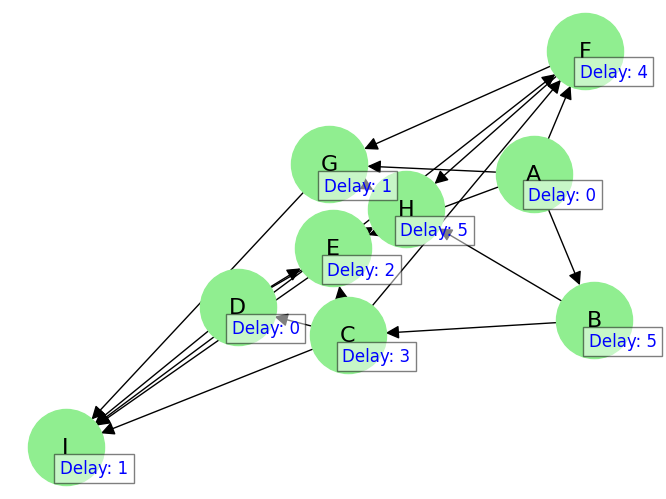

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/brute_force.json' mode='w' encoding='cp1252'>


In [162]:
path = 'test_files/'
files = os.listdir(path)
# Filter files that match the pattern 'test_file_*.py'
data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
data_to_write = []
# Loop through each file and import the data
for file_name in data_files:
    file_path = os.path.join(path, file_name)
    with open(file_path, 'r') as f:
        loaded_data = json.load(f)
        tasks = loaded_data.get('tasks')
        edges = loaded_data.get('edges')
        delays = loaded_data.get('delays')

        finish_times, finish_time, order_of_tasks, time_taken = brute_force_alg(edges)
        draw_graph(tasks, edges, delays)
        print("----------------------------------------------")
        data = {
        'test_name' : file_name,
        'order_of_tasks': order_of_tasks,
        'finish_times': finish_times,
        'finish_time': finish_time,
        'time_taken': time_taken
        }
        data_to_write.append(data)

result_file = 'results/brute_force.json'
save_results(result_file, data_to_write)

In [128]:
# def top_sort(tasks, graph):
#     in_degree = {t: 0 for t in tasks}
#     for u in graph:
#         for v in graph[u]:
#             in_degree[v] += 1
    
#     queue = deque([t for t in tasks if in_degree[t] == 0])
#     top_order = []
    
#     while queue:
#         node = queue.popleft()
#         top_order.append(node)
        
#         for neighbor in graph[node]:
#             in_degree[neighbor] -= 1
#             if in_degree[neighbor] == 0:
#                 queue.append(neighbor)
    
#     return top_order

In [129]:
# def mpcs(tasks, edges, delays):
#     graph = defaultdict(list)
#     predak = defaultdict(list)
#     # finish_times = {t: delays[t] for t in tasks}
    
#     for u, v in edges:
#         graph[u].append(v)
#         predak[v].append(u)
#     start_time = time.time()
#     top_order = top_sort(tasks, graph)
    
#     for i in range(1, len(top_order)):
#         finish_times[top_order[i]] += finish_times[top_order[i-1]] + 1
    
#     finish_time = max(finish_times.values())
    
#     end_time = time.time()
#     time_taken = end_time - start_time
#     return finish_times, finish_time, top_order, time_taken

### Za velike podatke 

In [14]:
# tasks = [f'T{i}' for i in range(1, 9990001)]

In [11]:
# import random

# edges = []
# for i in range(1, 9990001):
#     # Define the range of nodes that can be connected to
#     start = i + 1
#     end = min(i + 5, 9990001)  # Ensure we do not go out of bounds
#     # Compute the maximum number of targets we can sample
#     max_targets = end - start
#     if max_targets > 0:
#         num_connections = random.randint(1, min(5, max_targets))  # Random number of connections within the bounds
#         targets = random.sample(range(start, end), num_connections)
#         for target in targets:
#             edges.append((f'T{i}', f'T{target}'))

In [12]:
# import random

# delays = {f'T{i}': random.randint(1, 10) for i in range(1, 9990001)}

In [13]:
# dp, finish_time = mpcs(tasks, edges, delays)

# print("Earliest completion times for each task:", dp)
# print("Minimum finish time:", finish_time)